In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [5, 10, 20, 40, 80, 160, 320]
#multi_periods = [5, 7, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 160, 320, 640] 
#multi_periods = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 60, 80, 100, 120, 140, 160] 
roc_periods = [5, 10]
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20190101': '20191231']

In [4]:
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

9915.49165665634

In [5]:
vol_candles = group_by_volume(contract, avg_vol)

In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
def ema(data, periods):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    up = (data.ema_fast > data.ema_slow) * 1
    down = (data.ema_fast < data.ema_slow) * 1
    return up - down

In [8]:
def breakout(data, periods):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).rename(periods, inplace=True)

In [9]:
def diff(data, periods):
    up = (data.close.diff(periods) > 0) * 1
    down = (data.close.diff(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [10]:
def acc(data, periods):
    up = (data.close.pct_change(periods).pct_change(periods) > 0) * 1
    down = (data.close.pct_change(periods).pct_change(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [11]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [12]:
vols = vol(data, vol_lookback)

In [13]:
def combine(data, multi_periods, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p) for p in multi_periods]).T.sum(axis=1)
    return result

In [14]:
forecasts = pd.DataFrame([breakout(data, p) for p in multi_periods]).T

In [15]:
forecasts

,2,3,4,5,6,7,8,9,10,15,20,30,40,60,80,100,120,140,160
label,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7439,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7440,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7441,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0


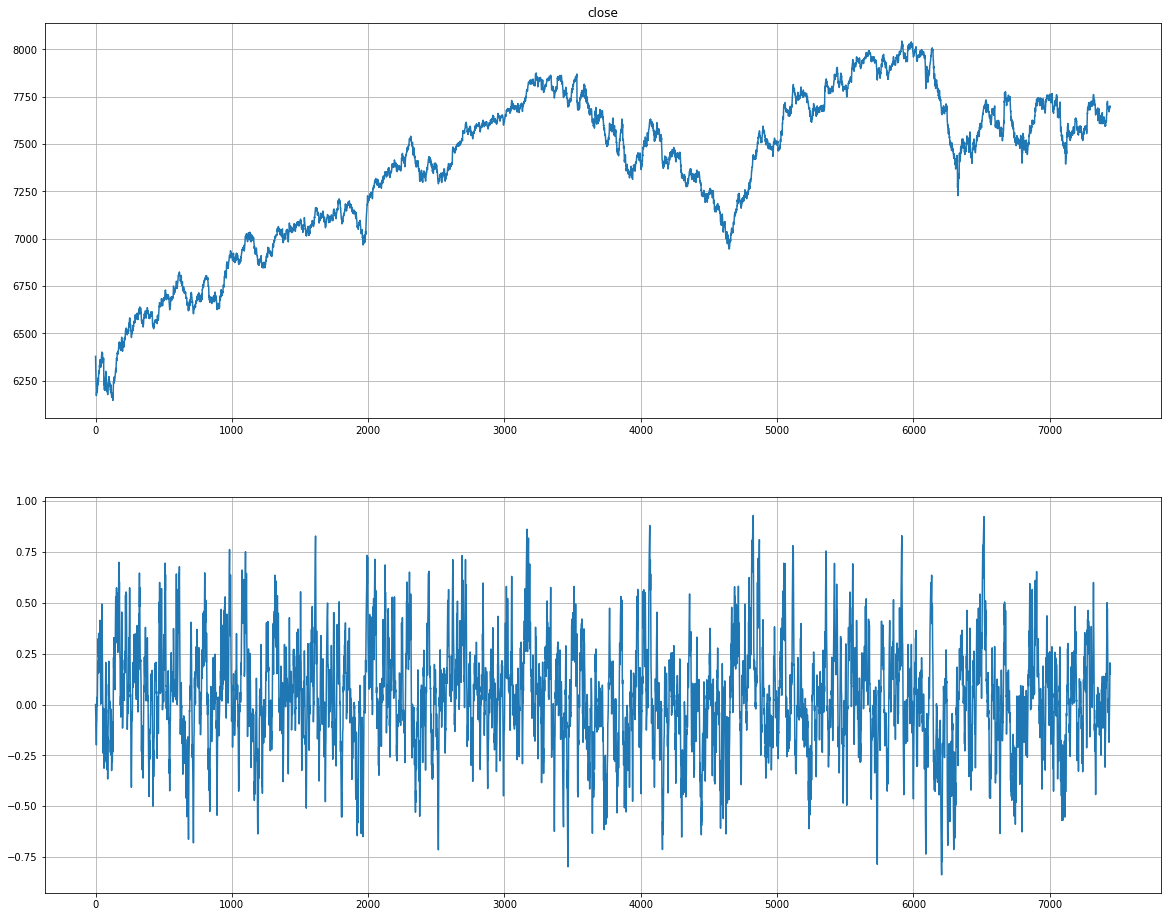

In [16]:
plot(data.close, forecasts.mean(axis=1).ewm(span=10).mean())

In [17]:
combined_forecast = forecasts.mean(axis=1).ewm(span=10).mean().rename('combined')
combined_forecast = combined_forecast*20

In [18]:
combined_forecast.abs().mean(), combined_forecast.abs().std()

(3.9905110536186377, 3.301207431364112)

In [19]:
#forecasts = (combine(data, multi_periods, [breakout])*multiplier).clip(lower=-20, upper=20)
#forecasts['diff'] = pd.DataFrame([diff(data, p) for p in roc_periods]).T.mean(axis=1)
#forecasts['combined'] = forecasts.sum(axis=1).ewm(span=50).mean()

In [20]:
data = data.join(combined_forecast)
data = data.iloc[200:]

In [21]:
#plot(data[['close',  'ema','combined']])

In [22]:
output = data.set_index('date')[['open','combined']]

In [23]:
out = summary(output.open, output.combined, slip=1.5)

In [24]:
out.stats

,0,3,5,6,7,10,15,17
Annual return,0.221676,0.14554,0.00801486,0.0314378,-0.00852919,-0.0042252,0.00324307,0.000225499
Cumulative returns,0.148262,0.0983613,0.00552723,0.0216029,-0.00589701,-0.00291931,0.00223814,0.000155697
Annual volatility,0.151432,0.118936,0.101023,0.0774219,0.06312,0.0390557,0.0164491,0.00204232
Sharpe ratio,1.39812,1.20165,0.129217,0.438346,-0.104353,-0.0890343,0.204991,0.111416
Calmar ratio,2.70934,2.54155,0.0932119,0.632041,-0.187139,-0.123072,0.362719,0.199769
Stability,0.694051,0.72431,0.537047,0.620778,0.418517,0.039152,0.296258,0.0213594
Max drawdown,-0.0818192,-0.0572644,-0.0859854,-0.0497402,-0.0455768,-0.0343311,-0.00894099,-0.0011288
Omega ratio,1.26439,1.23458,1.02424,1.08774,0.980954,0.979283,1.13284,1.12813
Sortino ratio,2.07604,2.03944,0.19122,0.636027,-0.156517,-0.146744,0.367446,0.194002
Skew,-0.333572,0.654712,0.136933,-0.229487,0.366291,1.20707,4.53755,4.80647


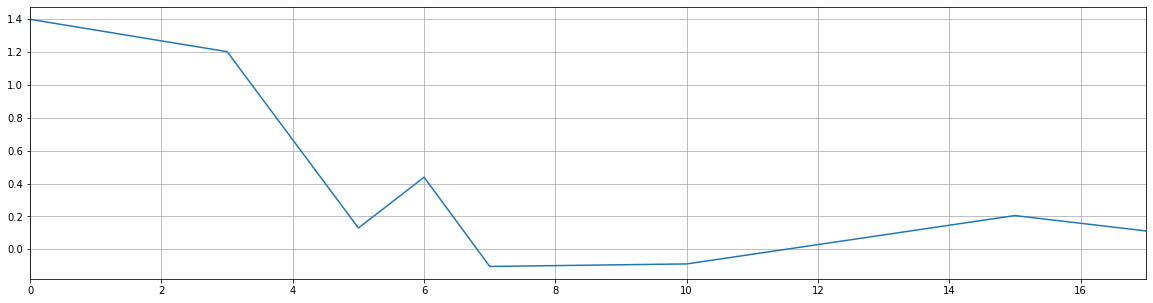

In [25]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

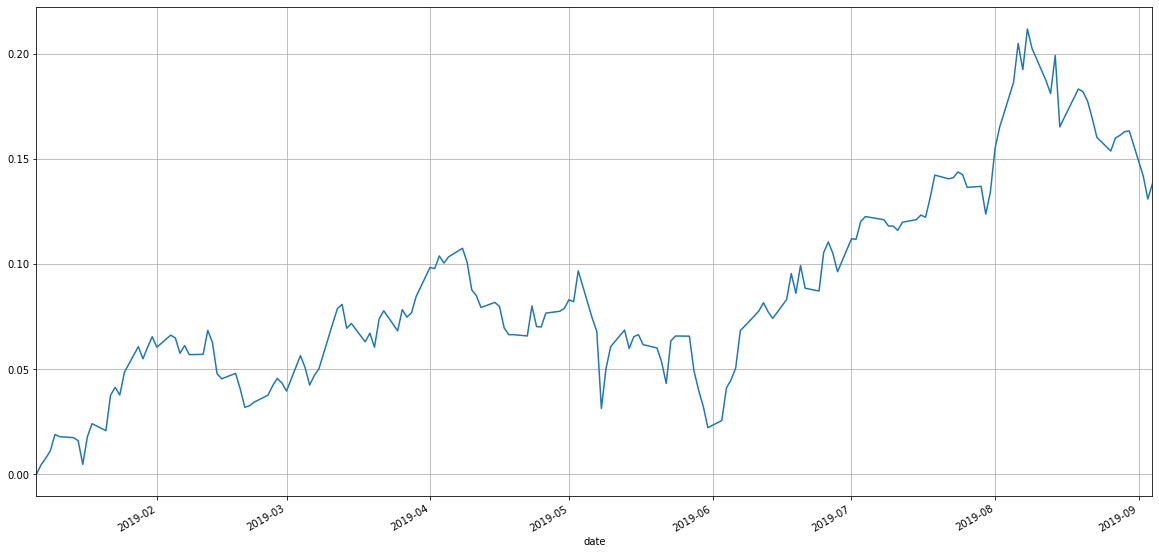

In [26]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [27]:
np.log(out.returns[4]+1).cumsum().plot(figsize=(20, 10), grid=True);

KeyError: 4

In [ ]:
chart_price(output.open.iloc[-1000:], output.combined.iloc[-1000:], 0);